In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from dataloader import Dataset_from_pkl
torch.manual_seed(1)



In [876]:
def create_line():    
    init = torch.rand(8,2)*3
    dt = init[1,:] - init[0,:]
    for i in range (2,8):
        init[i,:] = init[i - 1,:] + (dt  + torch.rand(1,2)/2)
    return init

def create_2person_traj(do_print=False):    
    init = torch.rand(2,8,2)*3
    dt = torch.zeros(2,2)
    
    dist = torch.norm(init[1, 1, :] - init[0, 1, :])
    if dist <1. :
        init[1, 1, :] += (init[1, 1, :] - init[0, 1, :]) / (dist*3)
        init[0, 1, :] += (init[0, 1, :] - init[1, 1, :]) / (dist*3)
        if do_print: 
                print ("interaction")
                print (init[0, 1, :])
                print (init[1, 1, :])
    
    dt[0, :] = init[0, 1,:] - init[0,0,:]
    dt[1, :] = init[1, 1,:] - init[1,0,:]
    for timestamp in range(2,8):
        for p in range(2):
            init[p, timestamp, :] = init[p, timestamp-1, :] + dt[p, :]  + torch.rand(1,2)/4
        dist = torch.norm(init[1, timestamp, :] - init[0, timestamp, :])
        if dist <3. :
            init[1, timestamp, :] += (init[1, timestamp, :] - init[0, timestamp, :]) / (dist*3)
            init[0, timestamp, :] += (init[0, timestamp, :] - init[1, timestamp, :]) / (dist*3)
            if do_print: 
                print ("interaction")
                print (init[0, timestamp, :])
                print (init[1, timestamp, :])
    return init


            
create_2person_traj().shape



torch.Size([2, 8, 2])

interaction
tensor([ 1.6755, -0.1964])
tensor([2.9855, 0.8485])


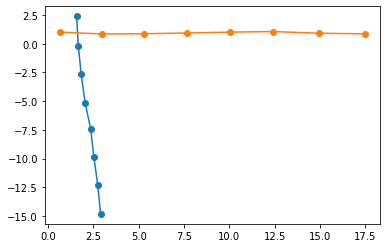

In [896]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_traj(data):
    #data shape [n, 2]
    x_poses = np.zeros((data.shape[0], data.shape[1]))
    y_poses = np.zeros((data.shape[0], data.shape[1]))
    for person in range(data.shape[0]):
        x_poses[person]  = data[person, :, 0].numpy()
        y_poses[person]  = data[person, :, 1].numpy()
    
    for person in range(data.shape[0]):
        plt.plot(x_poses[person], y_poses[person], 'o-')
    plt.show()
        
plot_traj(create_2person_traj(True))

In [670]:
input_dim = 2 # x, y
hidden_dim = 10
n_layers = 1
tagset_size = 2


class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim, input_dim, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

#         self.pose_embeddings = nn.Linear(input_dim, embedding_dim)

        self.node_future_encoder = nn.LSTM(input_size=input_dim,
                              hidden_size=hidden_dim,
                              bidirectional=True,
                              batch_first=True)

        self.edge_encoder = nn.LSTM(input_size=input_dim*2,
                                  hidden_size=hidden_dim,
                                  bidirectional=True,
                                  batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, self_pose, others_pose):
        # embeds = self.word_embeddings(sentence)
        # lstm_out, _ = self.lstm(sentence.view(len(sentence), 1, -1))
        lstm_out, _ = self.node_future_encoder(self_pose)
        edge_enc_hiden = torch.zeros(1,2,self.hidden_dim)
        for person in range(others_pose.shape[1]):
            other_pose = others_pose[:,person:person+1,:]
            concated = torch.cat((self_pose, other_pose),dim=-1)
            distr , _ = self.edge_encoder(concated)
#             distr , edge_enc_hiden = self.edge_encoder(concated, edge_enc_hiden)

        tag_space = self.hidden2tag(lstm_out + distr)
#         tag_space = self.hidden2tag(lstm_out)
#         tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_space




class LSTMsimple(nn.Module):

    def __init__(self, hidden_dim, input_dim, tagset_size):
        super(LSTMsimple, self).__init__()
        self.hidden_dim = hidden_dim

#         self.pose_embeddings = nn.Linear(input_dim, embedding_dim)

        self.node_future_encoder = nn.LSTM(input_size=input_dim,
                              hidden_size=hidden_dim,
                              bidirectional=True,
                              batch_first=True)

#         self.edge_encoder = nn.LSTM(input_size=input_dim*2,
#                                   hidden_size=hidden_dim,
#                                   bidirectional=True,
#                                   batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, self_pose, others_pose):
        # embeds = self.word_embeddings(sentence)
        # lstm_out, _ = self.lstm(sentence.view(len(sentence), 1, -1))
        lstm_out, _ = self.node_future_encoder(self_pose)
#         print ("lstm_out shape = ", lstm_out.shape)
#         edge_enc_hiden = torch.zeros(1, 2, self.hidden_dim)
#         for person in range(others_pose.shape[1]):
#             other_pose = others_pose[:,person:person+1,:]
#             concated = torch.cat((self_pose, other_pose),dim=-1)
#             distr , _ = self.edge_encoder(concated)
# #             distr , edge_enc_hiden = self.edge_encoder(concated, edge_enc_hiden)

        tag_space = self.hidden2tag(lstm_out)
#         tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_space


class LSTMDouble(nn.Module):

    def __init__(self, hidden_dim, input_dim, tagset_size):
        super(LSTMDouble, self).__init__()
        self.hidden_dim = hidden_dim

        self.node_future_encoder = nn.LSTM(input_size=input_dim,
                              hidden_size=hidden_dim,
                              bidirectional=True,
                              batch_first=True)
        
        self.node_future_encoder1 = nn.LSTM(input_size=2*hidden_dim,
                              hidden_size=2*hidden_dim,
                              bidirectional=True,
                              batch_first=True)
        self.hidden2tag = nn.Linear(4*hidden_dim, tagset_size)

    def forward(self, self_pose, others_pose):

        lstm_out, _ = self.node_future_encoder(self_pose)
        lstm_out, _ = self.node_future_encoder1(lstm_out)
        tag_space = self.hidden2tag(lstm_out)

        return tag_space


import torch.nn.functional as F
class Mlp(nn.Module):

    def __init__(self):
        super(Mlp, self).__init__()
        self.simple_linear = nn.Linear(2*4, 20)
        self.simple_linear1 = nn.Linear(20, 40)
        self.simple_linear2 = nn.Linear(40, 8)

    def forward(self, self_pose, others_pose):
        self_pose = self_pose.reshape(-1,8)
        out = F.relu(self.simple_linear (self_pose))
        out = F.relu(self.simple_linear1 (out))
        out = (self.simple_linear2 (out))
        

        return out.reshape(-1,4,2)
    
class OneLayer(nn.Module):

    def __init__(self):
        super(OneLayer, self).__init__()
        self.simple_linear = nn.Linear(2*4, 8)
#         self.simple_linear1 = nn.Linear(20, 40)
#         self.simple_linear2 = nn.Linear(40, 8)

    def forward(self, self_pose, others_pose):
        self_pose = self_pose.reshape(-1,8)
        out = self.simple_linear (self_pose)
       

        return out.reshape(-1,4,2)

In [801]:
class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, num_examples):
        'Initialization'
        self.num_examples = num_examples
        pass

    def __len__(self):
        'Denotes the total number of samples'
        return self.num_examples

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
#         data = create_line()
#         second_person = create_line()
#         data = torch.stack((data, second_person), dim=0)
        data = create_2person_traj()
        X = data[:,0:4,:].clone()
        # Load data and get label
#         X = torch.load('data/' + ID + '.pt')
        y = data[:,4:,:].clone()
        return X, y
    
    




In [2]:
# training_set = Dataset(3000)
training_set = Dataset_from_pkl("/home/robot/repos/trajectories_pred/processed/", data_files=["eth_train.pkl"])
training_generator = torch.utils.data.DataLoader(training_set, batch_size=1)

for local_batch in training_generator:
    print(local_batch.shape)
    break

loading eth_train.pkl
torch.Size([1, 3, 20, 8])


In [22]:
# model = LSTMsimple(hidden_dim, input_dim, tagset_size)
# model = LSTMDouble(hidden_dim, input_dim, tagset_size)
# model = Mlp()
model = OneLayer()
loss_function = nn.MSELoss()


NameError: name 'OneLayer' is not defined

In [811]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.1) # every 15 epochs drop by 0.1 lr

In [812]:
for epoch in range(20):
    summ_loss = 0
    for local_batch, local_labels in training_generator:
        for i in range(local_batch.shape[1]):
            model.zero_grad()
            prediction = model(local_batch[:,i,:,:], local_batch[:,i,:,:])
            loss = loss_function(prediction,local_labels[:,i,:,:])
            loss.backward()
        summ_loss += loss.item()
        optimizer.step()
        
    print ("epoch number {epoch} summ loss {summ_loss:.2f}".format(epoch=epoch, summ_loss=summ_loss))
    scheduler.step()
    
        

epoch number 0 summ loss 43.04
epoch number 1 summ loss 4.99
epoch number 2 summ loss 3.31
epoch number 3 summ loss 2.80
epoch number 4 summ loss 2.81
epoch number 5 summ loss 2.18
epoch number 6 summ loss 2.18
epoch number 7 summ loss 2.15
epoch number 8 summ loss 2.22
epoch number 9 summ loss 2.18
epoch number 10 summ loss 2.15
epoch number 11 summ loss 2.07
epoch number 12 summ loss 2.15
epoch number 13 summ loss 2.17
epoch number 14 summ loss 2.06
epoch number 15 summ loss 2.13
epoch number 16 summ loss 2.14
epoch number 17 summ loss 2.08
epoch number 18 summ loss 2.14
epoch number 19 summ loss 2.08


torch.Size([2, 8, 2])


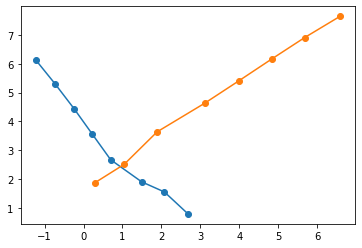

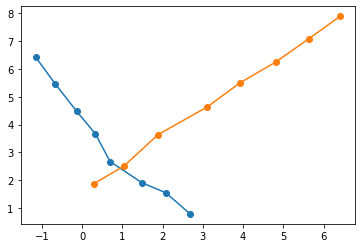

In [941]:
data = create_2person_traj()
print (data.shape)
inp = data[:,0:4, :]
out = data[:,4:,:]

pred = model(inp.unsqueeze(0), inp.unsqueeze(0))
# print("predict ",model(inp.unsqueeze(0), inp.unsqueeze(0)))
# print ()
# print("gt ", out)
# print ()
# print("error ", model(inp.unsqueeze(0), inp.unsqueeze(0)) - out)


to_plot = torch.cat((inp, pred.detach()),dim=1)

plot_traj(to_plot)
plot_traj(data)


In [3]:
test = nn.LSTM(input_size=2, hidden_size=3, batch_first=True)

In [26]:
seq_len = 6
torch.manual_seed(1)
inp = torch.rand(1,seq_len,2)
hid_state = torch.ones(1, 1, 3)
cell_state = torch.ones(1, 1, 3)
hid = (hid_state, cell_state)
# out, hid = test(inp.reshape(1,1,2), (hid_state, cell_state))
out, hid = test(inp.reshape(1,seq_len,2),hid)
print (inp)
print (out)

hid_state = torch.ones(1, 1, 3)
cell_state = torch.ones(1, 1, 3)
hid = (hid_state, cell_state)
for seq in range(inp.shape[1]):
    out, hid = test(inp[:,seq:seq+1,:],hid)
    print (out)


tensor([[[0.7576, 0.2793],
         [0.4031, 0.7347],
         [0.0293, 0.7999],
         [0.3971, 0.7544],
         [0.5695, 0.4388],
         [0.6387, 0.5247]]])
tensor([[[ 0.0580,  0.5463, -0.0572],
         [-0.0583,  0.2703, -0.2166],
         [-0.1203,  0.1745, -0.2683],
         [-0.1804,  0.1239, -0.2763],
         [-0.2091,  0.1069, -0.2865],
         [-0.2357,  0.0923, -0.2802]]], grad_fn=<TransposeBackward0>)
tensor([[[ 0.0580,  0.5463, -0.0572]]], grad_fn=<TransposeBackward0>)
tensor([[[-0.0583,  0.2703, -0.2166]]], grad_fn=<TransposeBackward0>)
tensor([[[-0.1203,  0.1745, -0.2683]]], grad_fn=<TransposeBackward0>)
tensor([[[-0.1804,  0.1239, -0.2763]]], grad_fn=<TransposeBackward0>)
tensor([[[-0.2091,  0.1069, -0.2865]]], grad_fn=<TransposeBackward0>)
tensor([[[-0.2357,  0.0923, -0.2802]]], grad_fn=<TransposeBackward0>)


In [32]:
t1 = torch.tensor([[1.,0.], [0.,1], [0., 0]])
t2 = torch.tensor([[1,0.], [0.,1], [0., 0]])

torch.norm((t2-t1), dim=1)

tensor([0., 0., 0.])

loading eth_train.pkl
loading zara2_test.pkl
5868
tensor([[[[ 6.5000e+01,  4.2600e+02,  4.3829e+00,  1.0424e+00, -8.1608e-01,
           -1.6885e-01, -2.3381e-01,  4.3444e-01],
          [ 6.5000e+01,  4.2700e+02,  4.0211e+00,  1.0407e+00, -9.1447e-01,
            1.4021e-02, -1.3549e-01,  2.5134e-01],
          [ 6.5000e+01,  4.2800e+02,  3.6514e+00,  1.0536e+00, -9.2447e-01,
            3.2219e-02, -8.8790e-03,  4.2884e-02],
          [ 6.5000e+01,  4.2900e+02,  3.2816e+00,  1.0665e+00, -9.2157e-01,
            4.8329e-02,  2.1704e-02,  1.2082e-01],
          [ 6.5000e+01,  4.3000e+02,  2.9141e+00,  1.0923e+00, -9.0710e-01,
            1.2888e-01,  3.2227e-02,  1.8161e-01],
          [ 6.5000e+01,  4.3100e+02,  2.5559e+00,  1.1696e+00, -8.9579e-01,
            1.9361e-01,  1.3812e-02,  8.0921e-02],
          [ 6.5000e+01,  4.3200e+02,  2.1975e+00,  1.2472e+00, -8.9606e-01,
            1.9361e-01, -1.2825e-02,  6.3394e-03],
          [ 6.5000e+01,  4.3300e+02,  1.8390e+00,  1.3245e+00